✅ Data berhasil dibaca!
Jumlah baris & kolom: (40, 6)

Preview Data:
       Unnamed: 0 Jumlah Penduduk Miskin menurut Provinsi (Ribu Jiwa)  \
0        Provinsi                                               2020    
1            Aceh                                             814.91    
2  Sumatera Utara                                           1,283.29    
3  Sumatera Barat                                             344.23    
4            Riau                                             483.39    

  Unnamed: 2 Unnamed: 3 Unnamed: 4 Unnamed: 5  
0       2021       2022       2023       2024  
1     834.24     806.82     806.75     804.53  
2   1,343.86   1,268.19   1,239.71   1,228.01  
3     370.67     335.21     340.37     345.73  
4     500.81     485.03     485.66     492.25  

Info Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 6 columns):
 #   Column                                               Non-Null Count  Dtype 
---  ----

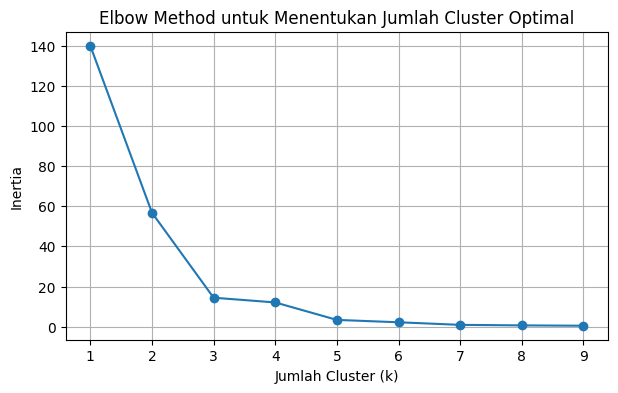


Hasil clustering (5 baris pertama):
   Unnamed: 5  Unnamed: 4  Unnamed: 3  \
0     2024.00     2023.00     2022.00   
1      804.53      806.75      806.82   
2      345.73      340.37      335.21   
3      492.25      485.66      485.03   
4      265.42      280.68      279.37   

   Jumlah Penduduk Miskin menurut Provinsi (Ribu Jiwa)  Unnamed: 2  Cluster  
0                                            2020.00       2021.00        2  
1                                             814.91        834.24        0  
2                                             344.23        370.67        1  
3                                             483.39        500.81        1  
4                                             277.80        293.86        1  


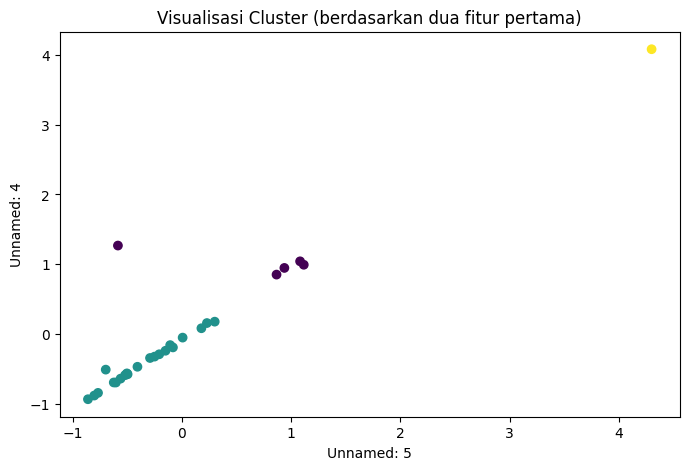


✅ Hasil clustering disimpan ke file: hasil_clustering_penduduk_miskin.csv


In [21]:
# ======================================================
# 📦 1️⃣ Import Library
# ======================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

# ======================================================
# 📂 2️⃣ Baca Dataset (Aman untuk Semua Format CSV)
# ======================================================
file_path = "Jumlah Penduduk Miskin Provinsi 2020-2025.csv"

try:
    df = pd.read_csv(file_path, encoding="utf-8")
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding="latin1")
except Exception as e:
    print("⚠️ Tidak bisa dibaca sebagai CSV, error:", e)

print("✅ Data berhasil dibaca!")
print("Jumlah baris & kolom:", df.shape)
print("\nPreview Data:")
print(df.head())

# ======================================================
# 🔍 3️⃣ Informasi Data dan Cek Missing Value
# ======================================================
print("\nInfo Data:")
print(df.info())

print("\nCek missing value:")
print(df.isna().sum())

# ======================================================
# 🧹 4️⃣ Otomatis Deteksi Kolom Numerik
# ======================================================
conv_stats = {}
for col in df.columns:
    coerced = pd.to_numeric(df[col], errors="coerce")
    non_na = coerced.notna().sum()
    unique_vals = coerced.nunique(dropna=True)
    conv_stats[col] = {"non_na": int(non_na), "unique": int(unique_vals)}

conv_df = pd.DataFrame(conv_stats).T.sort_values(by="non_na", ascending=False)
print("\nHasil deteksi konversi ke numeric (kolom, non-NA, unik):")
print(conv_df)

# Pilih kolom numerik minimal 50% data dan >1 unique value
n_rows = len(df)
candidate_cols = conv_df[
    (conv_df["non_na"] >= max(10, 0.5*n_rows)) &
    (conv_df["unique"] > 1)
].index.tolist()

print("\nKolom kandidat numerik:", candidate_cols)

if len(candidate_cols) < 2:
    raise ValueError("❌ Tidak cukup kolom numerik untuk clustering. Periksa dataset.")

# ======================================================
# 🧽 5️⃣ Pembersihan Data
# ======================================================
df_num = df[candidate_cols].apply(lambda s: pd.to_numeric(s, errors="coerce"))
df_num = df_num.dropna(how="any").reset_index(drop=True)

# Jika terlalu sedikit baris, isi NA dengan median
if len(df_num) < 10:
    df_num = df[candidate_cols].apply(lambda s: pd.to_numeric(s, errors="coerce"))
    df_num = df_num.fillna(df_num.median())

# Hapus kolom dengan varians nol
zero_var_cols = df_num.columns[df_num.var() == 0].tolist()
if zero_var_cols:
    print("Kolom varians 0 dibuang:", zero_var_cols)
    df_num = df_num.drop(columns=zero_var_cols)

# ======================================================
# ⚖️ 6️⃣ Standarisasi Data
# ======================================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_num)
print("\n✅ Standarisasi selesai! Shape data:", X_scaled.shape)

# ======================================================
# 📊 7️⃣ Menentukan Jumlah Cluster Optimal (Elbow Method)
# ======================================================
inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(7,4))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method untuk Menentukan Jumlah Cluster Optimal')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# ======================================================
# 🧩 8️⃣ Clustering dengan K=3 (atau sesuaikan setelah lihat grafik)
# ======================================================
kmeans = KMeans(n_clusters=3, random_state=42)
df_num["Cluster"] = kmeans.fit_predict(X_scaled)

print("\nHasil clustering (5 baris pertama):")
print(df_num.head())

# ======================================================
# 🌈 9️⃣ Visualisasi Cluster Sederhana
# ======================================================
plt.figure(figsize=(8,5))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=df_num["Cluster"], cmap='viridis')
plt.title("Visualisasi Cluster (berdasarkan dua fitur pertama)")
plt.xlabel(df_num.columns[0])
plt.ylabel(df_num.columns[1])
plt.show()

# ======================================================
# 💾 🔟 Simpan hasil clustering
# ======================================================
output_file = "hasil_clustering_penduduk_miskin.csv"
df_num.to_csv(output_file, index=False)
print(f"\n✅ Hasil clustering disimpan ke file: {output_file}")
